In [1]:
%pip install changeos

Note: you may need to restart the kernel to use updated packages.


In [2]:
# %pip install segment-geospatial groundingdino-py leafmap localtileserver opencv-python-headless

In [3]:
import os
os.chdir('/home/jovyan/EYODSC2024')

In [4]:
import azure.storage.blob


container_client = azure.storage.blob.ContainerClient(
    "https://eyodsc2024.blob.core.windows.net",
    container_name="training-data",
    credential='sp=racwdli&st=2024-02-17T18:57:34Z&se=2024-03-31T02:57:34Z&spr=https&sv=2022-11-02&sr=c&sig=%2BMxPLgtEZ2%2Fjiyox5WOxgtxNkoGjBrKKNxVzt5k3k8s%3D',
)

# ChangeOS

In [5]:
import changeos

# constructing ChangeOS model
# support 'changeos_r18', 'changeos_r34', 'changeos_r50', 'changeos_r101'
model = changeos.from_name('changeos_r101') # take 'changeos_r101' as example


In [6]:
import geopandas as gpd

# Read the building footprints shapefile
building_footprints = gpd.read_file('Buildings Footprint ROI/building_footprint_roi_challenge.shp')
building_footprints=building_footprints.drop(columns=['area_in_me'])

# Convert the coordinate reference system (CRS) to EPSG 32620 -> 32619
building_footprints = building_footprints.to_crs(epsg=32619)

# Calculate the area in square meters
building_footprints['area_in_sqm'] = building_footprints.geometry.area
# Filter
# Set 100m^2 threshold
print(building_footprints.shape)
building_footprints=building_footprints[building_footprints['area_in_sqm']>=100]
print(building_footprints.shape)
building_footprints=building_footprints[building_footprints['confidence']>=0.8]
print(building_footprints.shape)

(281572, 6)
(142378, 6)
(114197, 6)


## Process All

In [7]:
from concurrent.futures import ThreadPoolExecutor
import rasterio
from rasterio.plot import reshape_as_image
from rasterio.features import rasterize

import json
from shapely.geometry import Polygon, mapping
import numpy as np
import io
import numpy as np
from concurrent.futures import ProcessPoolExecutor
import multiprocessing
import matplotlib.pyplot as plt
from shapely.affinity import scale, translate

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
                            np.int16, np.int32, np.int64, np.uint8,
                            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32,
                              np.float64)):
            return float(obj)
        elif isinstance(obj, (np.ndarray,)):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


def bbox_to_polygon(bbox):
    minx, miny, maxx, maxy = bbox.left, bbox.bottom, bbox.right, bbox.top
    polygon = Polygon([(minx, miny), (minx, maxy), (maxx, maxy), (maxx, miny)])
    return polygon

new_width=1024
old_width=512

new_height=1024
old_height=512

pad_left = (new_width - old_width) // 2
pad_right = new_width - old_width - pad_left
pad_top = (new_height - old_height) // 2
pad_bottom = new_height - old_height - pad_top

start_x = (new_width - old_width) // 2
end_x = start_x + old_width
start_y = (new_height - old_height) // 2
end_y = start_y + old_height

def get_image(path):
    blob = container_client.get_blob_client(blob=path)
    file = io.BytesIO(blob.download_blob().readall())
    with rasterio.open(file) as src:
        raster = src.read()
        boundary=src.bounds
    
    img=reshape_as_image(raster)
    
    img_padded = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
    boundary = bbox_to_polygon(boundary)
    return img, img_padded, boundary

# Rasterize
def geom_to_raster(geometry, transform, out_shape):
    return rasterize([(mapping(geometry.boundary), 1)], out_shape=out_shape, fill=0, transform=transform, all_touched=True, dtype='uint8')

colors = {
    1: [0, 0, 1, 0.2], # Blue
    2: [1, 1, 0, 0.2],  # Yellow (R=1, G=1, B=0, A=1)
    3: [1, 0.647, 0, 0.2],  # Orange (R=1, G=0.647, B=0, A=1)
    4: [0.6, 0.4, 0.2, 0.2],  # Brown (R=0.6, G=0.4, B=0.2, A=1)
    5: [1, 0, 0, 0.2]  # Red (R=1, G=0, B=0, A=1)
}

def tagging_pipeline(idx, visualise=False):
    info=dict()
    print(f"Tagging pipeline started for idx: {idx}")

    # Get pre-disaster image
    pre_img_path = f'Pre_Event_Grids_In_TIFF/Pre_Event_{idx:05}.tif'
    pre_img, pre_img_padded, pre_boundary = get_image(pre_img_path)

    # Get post-disaster image
    post_img_path = f'Post_Event_Georeference_Grids_In_TIFF/Post_Event_{idx:05}.tif'
    post_img, post_img_padded, post_boundary = get_image(post_img_path)

    print(f"Tagging pipeline image downloaded for idx: {idx}")

    # Find building footprints
    building_footprints_intersects=building_footprints[building_footprints.intersects(pre_boundary)]
    if not building_footprints_intersects.empty:
        info['ey']=dict()
        info['ey']['num_of_building'] = building_footprints_intersects.shape[0]
        info['ey']['mean_building_sqm'] = building_footprints_intersects['area_in_sqm'].mean()
        info['ey']['num_building_gt_500_sqm']= building_footprints_intersects[building_footprints_intersects['area_in_sqm']>500].shape[0]
    
    print(f"Tagging pipeline building footprints extracted for idx: {idx}")

    # Prediction
    # model inference
    localisation, damage = model(pre_img_padded, post_img_padded)
    localisation=localisation[start_y:end_y, start_x:end_x]
    damage=damage[start_y:end_y, start_x:end_x]
    print(f"Tagging pipeline prediction extracted for idx: {idx}")

    info['changeos']=dict()
    info['changeos']['ratio_of_building'] = localisation.mean()

    if info['changeos']['ratio_of_building']>0:
        info['changeos']['damaged_building_vs_all_building'] = np.sum(damage>1)/localisation.sum()

    # Output
    # info['pre_img']=pre_img
    # info['post_img']=post_img
    info['boundary']=str(pre_boundary)
    print(info)

    # Define the file path
    file_path = os.path.join("Data Selection", f"{idx:05}.json")

    # Save the info dictionary as a JSON file
    with open(file_path, "w") as file:
        json.dump(info, file, indent=4, cls=NumpyEncoder)
    
    # Print complete message
    print(f"Tagging pipeline completed for idx: {idx}")

    if visualise:

        # Step 2: Clip the GeoDataFrame
        bbox = gpd.GeoDataFrame({'geometry': pre_boundary}, index=[0], crs=building_footprints_intersects.crs)
        clipped_gdf = gpd.clip(building_footprints_intersects, bbox)
        

        # Step 3: Rasterize the clipped GeoDataFrame
        # Define the transformation and raster size
        transform = rasterio.transform.from_bounds(*pre_boundary.bounds, width=512, height=512)
        out_shape = (512, 512)
        rasterized_image = np.zeros(out_shape, dtype='uint8')  # Initialize the raster array

        for geom in clipped_gdf.geometry:
            rasterized_image |= geom_to_raster(geom, transform, out_shape)

            
        fig, axs = plt.subplots(2, 2, figsize=(12, 12))

        # Visualize pre_img
        axs[0, 0].imshow(pre_img)
        axs[0, 0].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[0, 0].set_title('Pre-Disaster Image')

        # Visualize post_img
        axs[0, 1].imshow(post_img)
        axs[0, 1].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[0, 1].set_title('Post-Disaster Image')
        axs[0, 1].axis('off')

        # Assuming pre_img, post_img, localisation, and damage are already loaded and are of the same shape

       # Initialize an RGBA image for localisation overlay
        localisation_overlay = np.zeros((*localisation.shape, 4))

        # Set the color for non-zero pixels in localisation
        localisation_overlay[localisation == 1] = colors[1]

        # Ensure pre_img is in [0, 1] range if it's not already
        if pre_img.max() > 1:
            pre_img = pre_img / 255.0

        # Create a placeholder for the blended image
        blended_localisation_image = np.zeros_like(pre_img)

        # Blend the localisation_overlay with pre_img
        for i in range(3):  # For RGB channels
            blended_localisation_image[..., i] = (1 - localisation_overlay[..., 3]) * pre_img[..., i] + localisation_overlay[..., 3] * localisation_overlay[..., i]


        # Initialize an RGBA image based on post_img dimensions, filled with transparent pixels
        damage_overlay = np.zeros((*damage.shape, 4))

        # Process damage levels
        for level in range(1, 5+1):  # Loop through levels 1 to 5
            mask = damage == level
            damage_overlay[mask] = colors[level]
        
        # Blend damage_overlay with post_img
        # First, ensure post_img is in [0, 1] range if it's not already
        if post_img.max() > 1:
            post_img = post_img / 255.0

        # Create a placeholder for the blended image
        blended_damage_image = np.zeros_like(post_img)

        # Blend the images
        for i in range(3):  # For RGB channels
            blended_damage_image[..., i] = (1 - damage_overlay[..., 3]) * post_img[..., i] + damage_overlay[..., 3] * damage_overlay[..., i]

        # Now, you can visualize localisation_colored and damage_colored instead of localisation and damage
        # For example, to visualize the localisation with replaced black pixels:
        axs[1, 0].imshow(blended_localisation_image)
        # axs[1, 0].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[1, 0].set_title('Localisation')
        axs[1, 0].axis('off')

        # And for damage visualization:
        axs[1, 1].imshow(blended_damage_image)
        # axs[1, 1].imshow(rasterized_image, cmap='gray', alpha=0.5)
        axs[1, 1].set_title('Damage')
        axs[1, 1].axis('off')



        # Adjust the layout
        plt.tight_layout()



In [8]:
# Read selected_df_info
import pandas as pd
selected_df=pd.read_csv('./selected_df_info.csv')
selected_df

,boundary,index,ey_num_of_building,ey_mean_building_sqm,changeos_ratio_of_building,changeos_damaged_building_vs_all_building
0,"POLYGON ((807010.5000016 2035782.46911, 807010...",4807,21.0,232.919802,0.403114,0.757045
1,"POLYGON ((805916.7500016 2030157.46911, 805916...",6476,19.0,156.229979,0.211330,0.599686
2,"POLYGON ((801698.0000016 2033907.46911, 801698...",4386,11.0,631.092208,0.245975,0.506444
3,"POLYGON ((796854.2500016 2033438.71911, 796854...",2945,22.0,274.024917,0.183697,0.000000
4,"POLYGON ((796854.2500016 2043438.71911, 796854...",4364,17.0,162.243876,0.163128,0.000000
...,...,...,...,...,...,...
2906,"POLYGON ((804354.2500016 2034844.96911, 804354...",7333,40.0,257.485352,0.414211,0.000000
2907,"POLYGON ((799823.0000016 2040782.46911, 799823...",3795,19.0,148.980772,0.254612,0.000000
2908,"POLYGON ((805604.2500016 2038126.21911, 805604...",7476,9.0,819.955778,0.157131,0.000000
2909,"POLYGON ((800291.7500016 2031719.96911, 800291...",8268,30.0,206.412881,0.245743,0.153632


In [9]:
import shutil
shutil.rmtree('./Data Selection')


In [12]:
import warnings
warnings.filterwarnings('ignore')   

print(selected_df['index'].unique())
for id in selected_df['index'].unique():
    tagging_pipeline(id)



[4807 6476 4386 ... 7476 8268 3980]
Tagging pipeline started for idx: 4807
Tagging pipeline image downloaded for idx: 4807
Tagging pipeline building footprints extracted for idx: 4807
Tagging pipeline prediction extracted for idx: 4807
{'ey': {'num_of_building': 21, 'mean_building_sqm': 232.91980193089032, 'num_building_gt_500_sqm': 0}, 'changeos': {'ratio_of_building': 0.40311431884765625, 'damaged_building_vs_all_building': 0.757045252379961}, 'boundary': 'POLYGON ((807010.5000016 2035782.46911, 807010.5000016 2035938.71911, 807166.7500016 2035938.71911, 807166.7500016 2035782.46911, 807010.5000016 2035782.46911))'}
Tagging pipeline completed for idx: 4807
Tagging pipeline started for idx: 6476
Tagging pipeline image downloaded for idx: 6476
Tagging pipeline building footprints extracted for idx: 6476
Tagging pipeline prediction extracted for idx: 6476
{'ey': {'num_of_building': 19, 'mean_building_sqm': 156.2299789702256, 'num_building_gt_500_sqm': 0}, 'changeos': {'ratio_of_building

## Validation

In [46]:
# from PIL import Image

# def get_image_validation(path):
#     img = Image.open(path)
#     img_padded = np.pad(img, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
#     return img, img_padded


# def tagging_pipeline_validation(idx, visualise=False):
#     info=dict()
#     print(f"Tagging pipeline started for idx: {idx}")

#     # Get pre-disaster image
#     img_path = f'Submission data/Validation_Post_Event_{idx:03}.jpg'
#     img, img_padded = get_image_validation(img_path)

#     # Prediction
#     # model inference
#     localisation, damage = model(img_padded, img_padded)
#     localisation=localisation[start_y:end_y, start_x:end_x]
#     damage=damage[start_y:end_y, start_x:end_x]
#     print(f"Tagging pipeline prediction extracted for idx: {idx}")

#     info['ratio_of_building'] = localisation.mean()

#     if info['ratio_of_building']>0:
#         info['damaged_building_vs_all_building'] = np.sum(damage>1)/localisation.sum()


#     if visualise:
#         # Create a 1x2 subplot
#         fig, axs = plt.subplots(1, 2, figsize=(12, 12))

#         # Visualize img
#         axs[0].imshow(img)
#         axs[0].set_title('Validation Image')
#         axs[0].axis('off')

#         # Visualize localisation
#         axs[1].imshow(localisation, cmap='gray')
#         axs[1].set_title('Localisation')
#         axs[1].axis('off')

#         # Adjust the layout
#         plt.tight_layout()
#     return info


# validation=dict()
# for i in range(0,12):
#     idx=i+1
#     validation[idx]=tagging_pipeline_validation(idx,visualise=False)

# import pandas as pd
# validation_df=pd.DataFrame.from_dict(validation, orient='index')
# validation_df

## Select
Initial: 0.1 - 0.5 of % of buildings

In [13]:
import pandas as pd
import glob
import json

# Path to the folder containing JSON files
folder_path = 'Data Selection/*.json'  # Update this path

# Create an empty DataFrame
df = pd.DataFrame()

# Iterate over all JSON files in the folder
for file_name in glob.glob(folder_path):
    # Read the current JSON file
    with open(file_name) as f:
        json_data = json.load(f)

    json_data['index'] = int(file_name.split('/')[-1].split('.')[0].split('_')[-1])
    
    # Depending on the structure of your JSON, you might need to process or normalize it before appending
    # For example, if json_data is a dictionary that fits directly as a DataFrame row
    temp_df = pd.DataFrame([json_data])
    
    # Append to the main DataFrame
    df = pd.concat([df, temp_df], ignore_index=True)
    print(file_name)

# Now, df contains all JSON files as rows
df

# Flatten 'col1' and 'col2', and merge back to the original dataframe
for col in ['ey', 'changeos']:
    flattened_col_df = pd.json_normalize(df[col])
    flattened_col_df.columns = [f"{col}_{subcol}" for subcol in flattened_col_df.columns]  # Prefix the column names to avoid collisions
    df = df.drop(columns=[col]).join(flattened_col_df)  # Drop the original dict columns and join with the flattened columns

# df now has the flattened columns from 'col1' and 'col2'
df.to_csv('./df_info_damage.csv',index=False)

Data Selection/04807.json
Data Selection/06476.json
Data Selection/04386.json
Data Selection/02945.json
Data Selection/04364.json
Data Selection/06066.json
Data Selection/04590.json
Data Selection/02594.json
Data Selection/03831.json
Data Selection/08083.json
Data Selection/07771.json
Data Selection/08466.json
Data Selection/08129.json
Data Selection/08198.json
Data Selection/08255.json
Data Selection/07841.json
Data Selection/10159.json
Data Selection/00458.json
Data Selection/07715.json
Data Selection/07937.json
Data Selection/01043.json
Data Selection/08919.json
Data Selection/06218.json
Data Selection/03901.json
Data Selection/04757.json
Data Selection/01545.json
Data Selection/02632.json
Data Selection/07935.json
Data Selection/08034.json
Data Selection/02729.json
Data Selection/09829.json
Data Selection/10381.json
Data Selection/10354.json
Data Selection/02457.json
Data Selection/00137.json
Data Selection/02382.json
Data Selection/00678.json
Data Selection/07205.json
Data Selecti

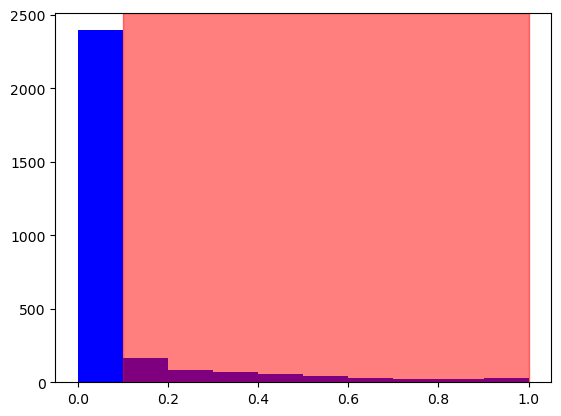

The percentage of values equals 0 is: 71.79663345929234%
The percentage of values between 0.1 and 1.0 is: 17.760219855719683%
The number of values between 0.1 and 1.0 is: 517


,boundary,index,ey_num_of_building,ey_mean_building_sqm,ey_num_building_gt_500_sqm,changeos_ratio_of_building,changeos_damaged_building_vs_all_building
1712,"POLYGON ((798104.2500016 2039688.71911, 798104...",10241,25.0,182.989923,0.0,0.327797,0.383952
607,"POLYGON ((799666.7500016 2032032.46911, 799666...",8678,52.0,188.549420,0.0,0.285934,0.117869
2206,"POLYGON ((801541.7500016 2040626.21911, 801541...",10204,46.0,180.745848,1.0,0.416958,0.455376
2246,"POLYGON ((799510.5000016 2028438.71911, 799510...",407,17.0,191.201031,0.0,0.159424,0.125191
2338,"POLYGON ((804041.7500016 2036719.96911, 804041...",8902,16.0,380.617885,6.0,0.187061,0.174175


In [32]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(df['changeos_damaged_building_vs_all_building'], color='blue')

# Color the bars between 0.1 and 1.0 in red
plt.axvspan(0.1, 1, color='red', alpha=0.5)

# Logarithmic scale

# Display the plot
plt.show()

# Print the percentage
percentage = ((df['changeos_damaged_building_vs_all_building']==0).sum() / len(df['changeos_damaged_building_vs_all_building'])) * 100
print(f"The percentage of values equals 0 is: {percentage}%")

percentage = (df['changeos_damaged_building_vs_all_building'].between(0.1, 1.0).sum() / len(df['changeos_damaged_building_vs_all_building'])) * 100
print(f"The percentage of values between 0.1 and 1.0 is: {percentage}%")
print(f"The number of values between 0.1 and 1.0 is: {df['changeos_damaged_building_vs_all_building'].between(0.1, 1.0).sum()}")

selected_df=df[df['changeos_damaged_building_vs_all_building'].between(0.1, 1.00)]
selected_df.sample(n=5)

In [33]:
selected_df.to_csv('./selected_df_info_damage.csv',index=False)

In [30]:
# # 512->1024
# # 1024*1024
# from PIL import Image
# import io
# import numpy as np

# pre_disaster_path='Pre_Event_Grids_In_TIFF/Pre_Event_04807.tif'
# post_disaster_path='Post_Event_Georeference_Grids_In_TIFF/Post_Event_04807.tif'

# pre_disaster_blob = container_client.get_blob_client(blob=pre_disaster_path)
# post_disaster_blob = container_client.get_blob_client(blob=post_disaster_path)

# # Read the image data into BytesIO objects
# pre_disaster_image = io.BytesIO(pre_disaster_blob.download_blob().readall())
# post_disaster_image = io.BytesIO(post_disaster_blob.download_blob().readall())

# # Convert image to data
# pre_disaster_data = np.array(Image.open(pre_disaster_image))
# post_disaster_data = np.array(Image.open(post_disaster_image))

# # Define new width and height
# new_width = 1024
# new_height = 1024

# # Reshape the data to match the expected input shape of the model
# pre_disaster_data = pre_disaster_data.reshape(pre_disaster_data.shape[0], pre_disaster_data.shape[1], 3)
# post_disaster_data = post_disaster_data.reshape(post_disaster_data.shape[0], post_disaster_data.shape[1], 3)


# # Calculate padding sizes
# pad_left = (new_width - pre_disaster_data.shape[1]) // 2
# pad_right = new_width - pre_disaster_data.shape[1] - pad_left
# pad_top = (new_height - pre_disaster_data.shape[0]) // 2
# pad_bottom = new_height - pre_disaster_data.shape[0] - pad_top

# print(pad_left,pad_right,pad_top,pad_bottom)
# # Add padding to the images
# pre_disaster_data = np.pad(pre_disaster_data, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)
# post_disaster_data = np.pad(post_disaster_data, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)), mode='constant', constant_values=0)


# # Print the shape of the data
# print("Pre-disaster data shape:", pre_disaster_data.shape)
# print("Post-disaster data shape:", post_disaster_data.shape)

# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 10))

# plt.subplot(121)
# plt.imshow(pre_disaster_data)
# plt.title('Pre-disaster Data')

# plt.subplot(122)
# plt.imshow(post_disaster_data)
# plt.title('Post-disaster Data')


# plt.tight_layout()
# plt.show()

## Organise Data

In [34]:
selected_df.shape

(517, 7)

In [35]:
from converter import convert_tiff_to_jpeg
def upload_files_to_blob(output_dir):
    output_dir=output_dir.replace('./','')
    print(output_dir)
    
    blobs = [blob for blob in container_client.list_blobs() if blob.name.startswith(output_dir)]
    for blob in blobs:
        container_client.delete_blob(blob)
    blobs = [blob.name for blob in container_client.list_blobs()]
    print(blobs)
    
    # Get a list of all files in the directory
    files = os.listdir(output_dir)

    # Loop through each file in the directory
    for file_name in files:
        # Construct the full path to the file
        if file_name=='.ipynb_checkpoints':
            continue

        file_path = os.path.join(output_dir, file_name)

        # Upload the file to Azure Blob storage
        with open(file_path, "rb") as data:
            # if file_path in blobs:
            #     continue
            container_client.upload_blob(name=file_path,data=data)


    print("Folder uploaded successfully.")

def download_image(path, name, output_dir):
    blob_client = container_client.get_blob_client(blob=path)
    with open(file=os.path.join(output_dir, name), mode="wb") as sample_blob:
        download_stream = blob_client.download_blob()
        sample_blob.write(download_stream.readall())

In [39]:
output_dir = "Training TIFF Damaged"

for i in selected_df['index']:
    pre_img_name=f'Pre_Event_{i:05}.tif'
    pre_img_path=f'Pre_Event_Grids_In_TIFF/{pre_img_name}'
    download_image(pre_img_path,pre_img_name, output_dir)

    post_img_name=f'Post_Event_{i:05}.tif'
    post_img_path=f'Post_Event_Georeference_Grids_In_TIFF/{post_img_name}'

    download_image(post_img_path,post_img_name, output_dir)

upload_files_to_blob(output_dir)


Training TIFF Damaged


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Folder uploaded successfully.


In [40]:
# specify directory
input_dir = "Training TIFF Damaged"
output_dir = "Training JPG Damaged"

convert_tiff_to_jpeg(input_dir,output_dir)
upload_files_to_blob(output_dir)


Conversion from TIFF to JPEG completed.
Training JPG Damaged


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



Folder uploaded successfully.
